,동리,침엽수_비율,활엽수_비율,총산림면적,리코드,산불_피해면적합계,산불_발생횟수,산불_진화시간합계,산불_평균피해면적,시간당_피해면적
429,강천리,60.44,39.56,1.239652e+07,4167037027,9500.0,1.0,994.0,9500.000000,9.557344
464,개운리,70.65,29.35,2.496717e+06,5172035229,8600.0,1.0,204.0,8600.000000,42.156863
471,개포리,61.64,38.36,5.338368e+06,4783035036,18000.0,1.0,1486.0,18000.000000,12.113055
967,관화리,77.05,22.95,3.021357e+06,4784031045,90100.0,2.0,1350.0,45050.000000,66.740741
1086,괴시리,78.15,21.85,4.261557e+06,4777036031,30000.0,1.0,332.0,30000.000000,90.361446
1704,금송리,65.92,34.08,1.196939e+07,4682041022,7000.0,1.0,244.0,7000.000000,28.688525
1806,기곡리,62.20,37.80,5.608124e+07,2771033023,56800.0,2.0,1493.0,28400.000000,38.044206
1906,김흥리,64.04,35.96,7.740873e+06,2771026228,31800.0,1.0,953.0,31800.000000,33.368311
1965,난지도리,65.86,34.14,3.265836e+06,4427032026,16000.0,2.0,989.0,8000.000000,16.177958
2431,녹산리,78.95,21.05,1.956955e+06,4687033022,24100.0,3.0,921.0,8033.333333,26.167210


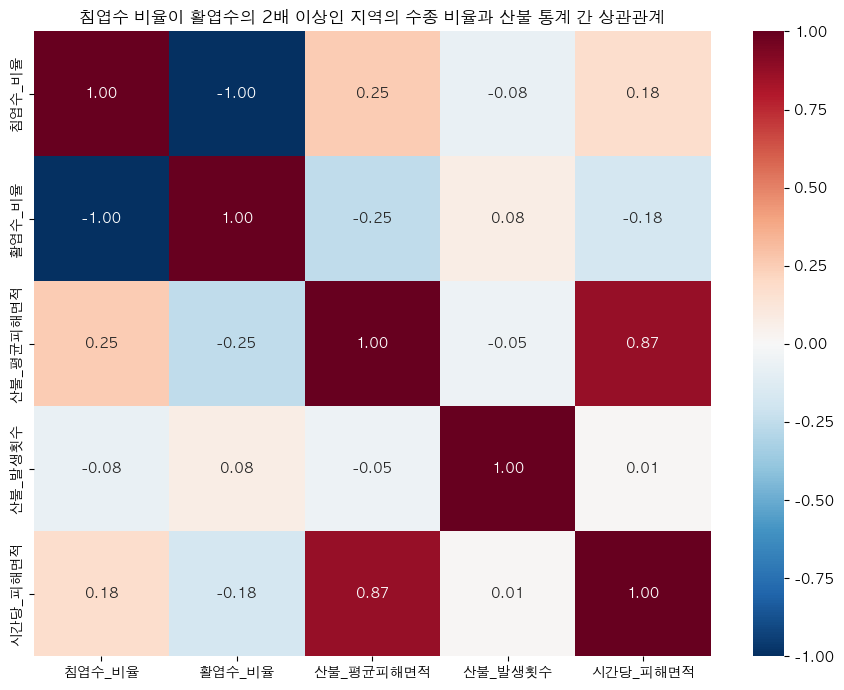

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  
plt.rcParams['axes.unicode_minus'] = False 

# 🔹 1. 데이터 불러오기
tree_ratio = pd.read_csv("../data/processed/수종분석데이터/리별_수종비율.csv", encoding="utf-8-sig")
fire = pd.read_csv("../data/processed/수종분석데이터/산불데이터_동리_전처리.csv", encoding="utf-8-sig")

# 🔹 2. 산불 통계 집계 (동리 기준)
fire_summary = fire.groupby("동리").agg(
    산불_피해면적합계=("피해면적_m2", "sum"),
    산불_발생횟수=("피해면적_m2", "count"),
    산불_진화시간합계=("진화시간_분", "sum")
).reset_index()

# 🔹 3. 병합
tree_ratio = tree_ratio.rename(columns={"리명": "동리"})
merged = pd.merge(tree_ratio, fire_summary, on="동리", how="left")

# 🔹 4. 산불 데이터 누락 처리
merged[["산불_피해면적합계", "산불_발생횟수", "산불_진화시간합계"]] = merged[[
    "산불_피해면적합계", "산불_발생횟수", "산불_진화시간합계"
]].fillna(0)

# 🔹 5. 파생 변수 생성
merged["산불_평균피해면적"] = merged["산불_피해면적합계"] / merged["산불_발생횟수"]
merged["시간당_피해면적"] = merged["산불_피해면적합계"] / merged["산불_진화시간합계"]
merged = merged.drop_duplicates(subset=["동리"])
# 🔹 6. 예외값 + 침엽수 조건 필터링
merged = merged[
    (merged["산불_발생횟수"] > 0) &
    (merged["산불_진화시간합계"] > 0) &
    (merged["산불_평균피해면적"] > 5000) &
    (merged["침엽수_비율"] > merged["활엽수_비율"] * 1.5)
]
display(merged.head(10))
# 🔹 7. 상관분석 대상 컬럼 선택
corr_cols = ["침엽수_비율", "활엽수_비율", "산불_평균피해면적", "산불_발생횟수", "시간당_피해면적"]
correlation = merged[corr_cols].corr()

# 🔹 8. 히트맵 시각화
plt.figure(figsize=(9, 7))
sns.heatmap(correlation, annot=True, cmap="RdBu_r", fmt=".2f")
plt.title("침엽수 비율이 활엽수의 2배 이상인 지역의 수종 비율과 산불 통계 간 상관관계")
plt.tight_layout()
plt.show()

In [4]:
from scipy.stats import pearsonr

# 대상 컬럼
cols = ["침엽수_비율", "활엽수_비율", "산불_평균피해면적", "산불_발생횟수", "시간당_피해면적"]

# 결과 저장용
results = []

# 모든 조합에 대해 상관계수와 p-value 계산
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        col1 = cols[i]
        col2 = cols[j]
        r, p = pearsonr(merged[col1], merged[col2])
        results.append({
            "변수1": col1,
            "변수2": col2,
            "상관계수": round(r, 2),
            "p값": round(p, 4),
            "유의": "✅ 유의함 (p<0.05)" if p < 0.1 else "❌ 유의하지 않음"
        })

# 데이터프레임으로 보기 좋게 정리
result_df = pd.DataFrame(results)
display(result_df)


,변수1,변수2,상관계수,p값,유의
0,침엽수_비율,활엽수_비율,-1.00,0.0000,✅ 유의함 (p<0.05)
1,침엽수_비율,산불_평균피해면적,0.25,0.0477,✅ 유의함 (p<0.05)
2,침엽수_비율,산불_발생횟수,-0.08,0.5548,❌ 유의하지 않음
3,침엽수_비율,시간당_피해면적,0.18,0.1767,❌ 유의하지 않음
4,활엽수_비율,산불_평균피해면적,-0.25,0.0477,✅ 유의함 (p<0.05)
5,활엽수_비율,산불_발생횟수,0.08,0.5548,❌ 유의하지 않음
6,활엽수_비율,시간당_피해면적,-0.18,0.1767,❌ 유의하지 않음
7,산불_평균피해면적,산불_발생횟수,-0.05,0.7065,❌ 유의하지 않음
8,산불_평균피해면적,시간당_피해면적,0.87,0.0000,✅ 유의함 (p<0.05)
9,산불_발생횟수,시간당_피해면적,0.01,0.9225,❌ 유의하지 않음


In [12]:
import pandas as pd

# 필요한 컬럼 존재 여부 확인
required_cols = ["동리", "활엽수_비율", "산불_발생횟수", "산불_평균피해면적"]
missing_cols = [col for col in required_cols if col not in merged.columns]
if missing_cols:
    raise ValueError(f"누락된 컬럼: {missing_cols}")

# 정렬: 활엽수 비율 낮은 순, 발생횟수 많은 순, 피해면적 큰 순
df_sorted = merged.sort_values(
    by=["활엽수_비율", "산불_발생횟수", "산불_평균피해면적"],
    ascending=[True, False, False]
)

# 상위 10개 행 추출 후 복사
top5 = df_sorted.head(10).copy()

# 표시용 컬럼 추가 (쉼표 포함 포맷)
top5["산불_평균피해면적_m2"] = top5["산불_평균피해면적"].apply(lambda x: f"{int(x):,}")

# 결과 출력
print("📌 활엽수 비율이 적고 산불피해가 큰 지역 Top 10:")
display(top5[["동리", "활엽수_비율", "산불_발생횟수", "산불_평균피해면적_m2"]])

📌 활엽수 비율이 적고 산불피해가 큰 지역 Top 10:


,동리,활엽수_비율,산불_발생횟수,산불_평균피해면적_m2
11413,의일리,10.08,1.0,"108,400"
11329,은포리,12.33,1.0,"10,000"
12364,좌곤리,12.96,1.0,"39,500"
7089,선지리,15.92,1.0,"6,000"
14624,환성리,17.23,2.0,"5,150"
13394,춘화리,17.86,1.0,"6,608,200"
6757,서동리,19.39,1.0,"6,899"
7675,송청리,20.02,1.0,"7,163,099"
2431,녹산리,21.05,3.0,"8,033"
1086,괴시리,21.85,1.0,"30,000"
